# <center>Anime Sketch Colorization <center>
  
### Problem Statement: To build a model a machine learning model which can create a color anime Image from the given black and which anime sketch image using GAN, Swish gated Residual Net.



In [1]:
# import Library Files 

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import LeakyReLU, Input, MaxPool2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.activations import tanh, sigmoid
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard

from datetime import datetime
from IPython import display
import math
import cv2



In [2]:
# To access the data from google drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


__Read Data from the file__        
I used only 3 folders images data for training there are 5944 images and 1 folder images for test there 1993 images.  

In [18]:
# Read data from drive
# I used only 2 floders for train the models
# 1 folder for test data
img_paths = glob.glob('/content/gdrive/My Drive/Case Study 2/Data/src/0000/*.png')
img_paths.extend(glob.glob('/content/gdrive/My Drive/Case Study 2/Data/src/0001/*.png'))
img_paths.extend(glob.glob('/content/gdrive/My Drive/Case Study 2/Data/src/0002/*.png'))

sketch_paths = glob.glob('/content/gdrive/My Drive/Case Study 2/Data/sketch/0000/*.png')
sketch_paths.extend(glob.glob('/content/gdrive/My Drive/Case Study 2/Data/sketch/0001/*.png'))
sketch_paths.extend(glob.glob('/content/gdrive/My Drive/Case Study 2/Data/sketch/0002/*.png'))

test_img_paths = glob.glob('/content/gdrive/My Drive/Case Study 2/Data/src/0003/*.png')
test_sketch_paths = glob.glob('/content/gdrive/My Drive/Case Study 2/Data/sketch/0003/*.png')

img_paths.sort()
sketch_paths.sort()

test_img_paths.sort()
test_sketch_paths.sort()

img_paths = np.array(img_paths)
sketch_paths = np.array(sketch_paths)

test_img_paths = np.array(test_img_paths)
test_sketch_paths = np.array(test_sketch_paths)

print (len(img_paths))
print (len(sketch_paths))

print (len(test_img_paths))
print (len(test_sketch_paths))

global TOTAL_IMAGES
TOTAL_IMAGES = len(img_paths)

TOTAL_TEST_IMAGES = len(test_img_paths)

5944
5944
1993
1993


__Sample Images__

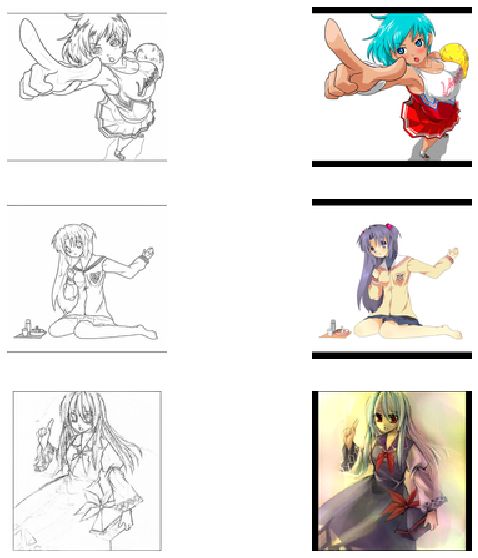

In [0]:
# To check the read files are correct or not?
# Sample color and sketch images
# Display Sample Data 

import matplotlib.image as mpimg
image1 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/sketch/0002/247002.png').convert('RGB')
image2 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/0002/247002.png')

image3 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/sketch/0001/174001.png').convert('RGB')
image4 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/0001/174001.png')

image5 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/sketch/0000/41000.png').convert('RGB')
image6 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/0000/41000.png')


plt.figure(figsize=(10,10))
plt.title("Skech Image and color Image")
plt.subplot(3, 2, 1)
plt.axis('off')
plt.imshow(image1)


plt.subplot(3, 2, 2)
plt.axis('off')
plt.imshow(image2)

plt.subplot(3, 2, 3)
plt.axis('off')
plt.imshow(image3)

plt.subplot(3, 2, 4)
plt.axis('off')
plt.imshow(image4)

plt.subplot(3, 2, 5)
plt.axis('off')
plt.imshow(image5)

plt.subplot(3, 2, 6)
plt.axis('off')
plt.imshow(image6)



### GAN Network 

__I used SGRU model.
In which Swish residual U-Net connection is used__  
Link: http://www.engineeringletters.com/issues_v27/issue_3/EL_27_3_01.pdf


### U-Net

In [0]:
def convolution(inp, n_filters, filter_size = 3, strides = 1, alpha = 0.2, batchNormalize = True):

  """
  Function for do convolution operation
  Paramerers : 
    inp(Tensor): Inputer tensor
    
    n_filters(int) : number of filters
    
    stride(int): Amount of stride required
    
    alpha: Alpha value for leaky realy activation
  
  Returns:   
    Tensor: A output tensor from convolution layer 
  """
  
  inp = Conv2D(n_filters, filter_size, strides, padding = 'same', kernel_initializer= tf.keras.initializers.truncated_normal(stddev=0.02) ) (inp)
  if batchNormalize:
    inp = BatchNormalization()(inp)
  inp = LeakyReLU(alpha = alpha)(inp)

  return inp

__Swish Layer__

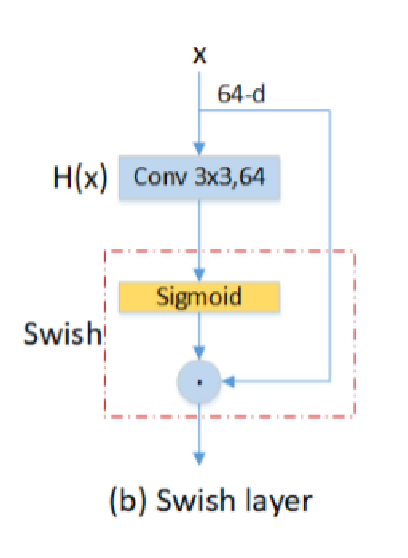

In [0]:

"""
Displaying the complete Swish Net.
"""
gan = Image.open('Screen/SwishNet.PNG').convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
# Swish Layer
def SwishMod(inp, filter_size = 3, stride = 2, padding ='same', batchNormalize = True, alpha = 0.2):

   """
    This Function perform swish layer operation
    
    Take input image perform conv operatin perform dot on input and conv output(multiply operation on both) return result element wise multimplication
    
    Filter are the channels in input images
    
    Here input and output are the same shape if input (64, 64, 3) output also (64, 64,3) 
  """
  filters = list(inp.get_shape())[-1]
  conv = Conv2D(filters, filter_size, padding = 'same', kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02))(inp)
  conv = sigmoid(conv)

  swished = tf.keras.layers.multiply([inp, conv])
  #print (swished.shape)

  return swished


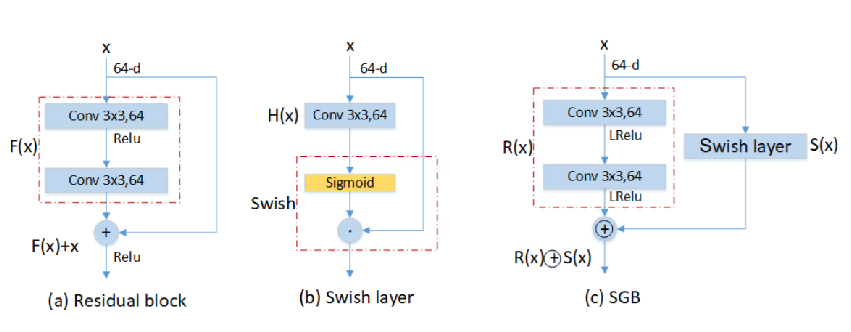

In [0]:

"""
Displaying the complete Residual Swish Net architechture.
"""
gan = Image.open('Screen/Capture.PNG').convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
def convBlock(inp, n_filters, filter_size = 3, padding = 'same', batchNormalize = True, con1X1 = True, cat = None, dropout = False, alpha = 0.2):

  '''
  Function for convolution block 
  
  It take input and perform convolution operation and generate output for next layer
  '''
  if con1X1:
    inp = convolution(inp, n_filters, filter_size,  batchNormalize=batchNormalize)

  conv1 = convolution(inp, n_filters, filter_size)
  conv2 = convolution(conv1, n_filters, filter_size)

  if cat is None:

    max1 = MaxPooling2D(pool_size = 2, strides = 2) (conv2)
    swish = MaxPooling2D(pool_size = 2, strides = 2) (inp)
    swish = SwishMod(swish)
    concat = tf.keras.layers.concatenate([max1, swish])
    

  else:

    sgb_op = Conv2DTranspose(n_filters, (2, 2), strides = (2, 2), padding = 'same', kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02))(conv2)
    sgb_op = BatchNormalization()(sgb_op)

    if dropout:
      sgb_op = Dropout(rate = 0.5) (sgb_op)
    sgb_op = LeakyReLU(alpha = alpha) (sgb_op)

    swish = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02)) (conv2)
    swish = BatchNormalization()(swish)
    if dropout:
      swish = Dropout(rate = 0.5) (swish)
    swish = LeakyReLU(alpha = 0.2)(swish)
    
    swish = SwishMod(swish)
    concat = tf.keras.layers.concatenate([sgb_op, swish, cat])

  return concat, conv2

#### Generator:  U-Net is a generator for this model

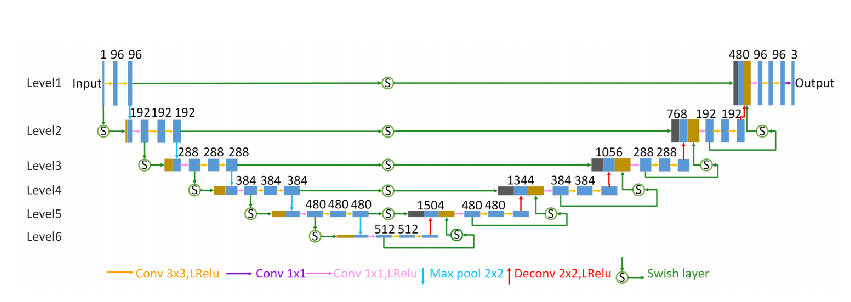

In [0]:
"""
Displaying the U-Net Structure architechture.
"""
gan = Image.open('Screen/Capture2.PNG').convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
# Define Generator Which is responsible for generating Fake data 

def Generator(inp_shape = (128, 128, 3)):
    '''
        A function for creating generator model.

      This function defines the generator part of the GAN with given input shape 
      using the Convolution and Convolution Transpose Blocks defined before.
      
      Takes the sketch input with values in the range [-1, 1] and generates the colored image of the same.

      Parameters:
        drop_rate (float): The drop out rate for regularizarition.
        
        alpha (float): The alpha value for LeakyReLu activation.
        
        inp_shape (tuple): The shape of input for initializing generator.
      
      Returns:
    tensorflow.keras.Model: The generator model initialized with a U-Net type enoder and decoder.
    '''

    n_filters = 64
    dropout = 0.5

    inp = Input(inp_shape)

    print ("Encoder")
    inputs, conv1 = convBlock(inp, n_filters, batchNormalize = False, con1X1 = False)
    inputs, conv2 = convBlock(inputs, n_filters * 2)
    inputs, conv3 = convBlock(inputs, n_filters * 3)
    inputs, conv4 = convBlock(inputs, n_filters * 4)
    inputs, conv5 = convBlock(inputs, n_filters * 5)
    inputs, conv6 = convBlock(inputs, n_filters * 6)

    conv1 = SwishMod(conv1)
    conv2 = SwishMod(conv2)
    conv3 = SwishMod(conv3)
    conv4 = SwishMod(conv4)
    conv5 = SwishMod(conv5)
    conv6 = SwishMod(conv6)
    print ("Decoder")
    inputs, _ = convBlock(inputs, n_filters * 6, cat = conv6, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 5, cat = conv5, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 4, cat = conv4, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 3, cat = conv3, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 2, cat = conv2, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 1, cat = conv1)

    out = Conv2D(3, 3, activation='tanh', padding = 'same' ) (inputs)

    model = Model(inputs=inp, outputs= out)

    opt = Adam(lr = 0.0002, beta_1 = 0.5)
    
    #model.compile(loss='binary_crossentropy', optimizer= opt)
    
    return model


In [0]:

model = Generator(inp_shape = (128, 128, 3))
model.summary()  

Encoder
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Decoder
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
_____________________________________________________________________________

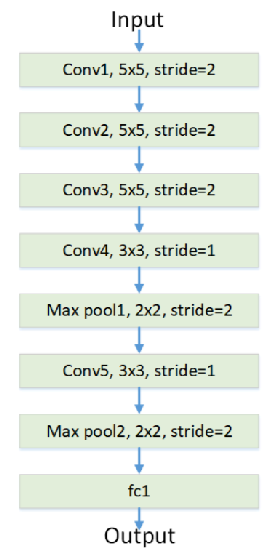

In [0]:
"""
Architecture of Discriminator.
"""
gan = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/DiscArchitecture.PNG').convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
# Discriminator Model

def Discriminator(input_shape = (128, 128, 3), target_shape = (128, 128, 3)):
  '''
    A function for creating discriminator model.

  This function defines the discriminator part of the GAN with given input shape & target shape 
  using the Convolution Blocks defined before.
  
  Takes the sketch and target image/generated colored image from generator with the values in the range [-1, 1] 
  and outputs the probability of being real/fake in the range [0, 1].

  Parameters:

    inp_shape (tuple): The shape of input for initializing generator.
    
    target_shape (tuple): The shape of the target output image. 
  
  Returns:
    tensorflow.keras.Model: The initialized discriminator model.
  '''

  n_filters = 64
  learning_rate = 0.0002

  inp1 = Input(input_shape)
  inp2 = Input(target_shape)

  inp = concatenate([inp1, inp2])

  conv = convolution(inp, n_filters, 5, strides = 2)
  conv = convolution(conv, n_filters *2, 5, strides = 2)
  conv = convolution(conv, n_filters *4, 5, strides = 1)

  maxPool = MaxPooling2D(pool_size= (2, 2))(conv)

  conv = convolution(maxPool, n_filters*8, 3, strides = 1)

  maxPool = MaxPool2D( pool_size=(2, 2))(conv)
  conv = Conv2D(1, 2, strides = 1, activation = 'sigmoid', padding = 'valid')(maxPool)

  out = GlobalAveragePooling2D()(conv)

  model = Model(inputs = [inp1, inp2], outputs = out)
  opt = Adam(lr = 0.0002, beta_1 = 0.5)

  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

  return model



In [0]:
model = Discriminator()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 128, 128, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 64, 64, 64)   9664        concatenate_12[0][0]       

__Pretrain VGG19__

In [8]:
"""
Download VGG19 model for extracting basic features like edges, shapes
"""
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19

vgg = VGG19(weights = 'imagenet', include_top = False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
80142336/80134624 [==============================] - 6s 0us/step


In [9]:
from tensorflow.keras.layers import ReLU
# Take different layers layer model of vgg19
vgg_net1_1 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block1_conv2').output))
vgg_net1_2 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block2_conv2').output))
vgg_net1_3 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block3_conv2').output))
vgg_net1_4 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block4_conv2').output))
vgg_net1_5 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block5_conv2').output))

vgg_net2_1 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block1_conv2').output))
vgg_net2_2 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block2_conv2').output))
vgg_net2_3 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block3_conv2').output))
vgg_net2_4 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block4_conv2').output))
vgg_net2_5 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block5_conv2').output))

vgg_net2_5.summary()


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

__Loss Function__
It take a layer wise loss in VGG19

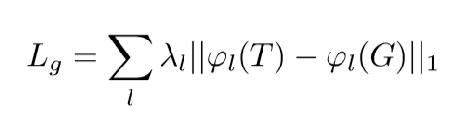

In [0]:
"""
Displaying the Loss Function .
"""
gan = Image.open('Screen/Loss Function.PNG').convert('RGB')

plt.figure(figsize=(8, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
# Custom Loss Function
# https://heartbeat.fritz.ai/how-to-create-a-custom-loss-function-in-keras-637bd312e9ab


def layer1_loss(y, g):
    
     """
      A loss for features extracted from 1th layer of VGG19.

      Custom loss for extracting high level features of the target colored and generated colored images.
      Taking the difference of VGG19 layer-1 output features as per reference paper.

      Parameters:
        y (Tensor): The target images to be generated.

        g (Tensor): The output images by generator.

      Returns:
        function: The reference to the loss function of prototype that keras requires.
     """
  
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )

  return layer_loss_value

def layer2_loss(y, g):
    
  """
  A loss for features extracted from 2th layer of VGG19.

  Custom loss for extracting high level features of the target colored and generated colored images.
  Taking the difference of VGG19 layer-2 output features as per reference paper.

  Parameters:
    y (Tensor): The target images to be generated.
    
    g (Tensor): The output images by generator.
  
  Returns:
    function: The reference to the loss function of prototype that keras requires.
  """  
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )

  return layer_loss_value

def layer3_loss(y, g):
 
  """
  A loss for features extracted from 3th layer of VGG19.

  Custom loss for extracting high level features of the target colored and generated colored images.
  Taking the difference of VGG19 layer-3 output features as per reference paper.

  Parameters:
    y (Tensor): The target images to be generated.
    
    g (Tensor): The output images by generator.
  
  Returns:
    function: The reference to the loss function of prototype that keras requires.
  """
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )

  return layer_loss_value

def layer4_loss(y, g):
  
  """
  A loss for features extracted from 4th layer of VGG19.

  Custom loss for extracting high level features of the target colored and generated colored images.
  Taking the difference of VGG19 layer-4 output features as per reference paper.

  Parameters:
    y (Tensor): The target images to be generated.
    
    g (Tensor): The output images by generator.
  
  Returns:
    function: The reference to the loss function of prototype that keras requires.
  """
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )
  
  return layer_loss_value

def layer5_loss(y, g):
    
  """
  A loss for features extracted from 5th layer of VGG19.

  Custom loss for extracting high level features of the target colored and generated colored images.
  Taking the difference of VGG19 layer-5 output features as per reference paper.

  Parameters:
    y (Tensor): The target images to be generated.
    
    g (Tensor): The output images by generator.
  
  Returns:
    function: The reference to the loss function of prototype that keras requires.
  """
  
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )

  return layer_loss_value 

def pixelLevel_loss(y, g):
    
   """
  A loss for pixel level loss

  Custom loss for extracting high level features of the target colored and generated colored images.
  Taking the difference of original and generated image.

  Parameters:
    y (Tensor): The target images to be generated.
    
    g (Tensor): The output images by generator.
  
  Returns:
    function: The reference to the loss function of prototype that keras requires.
  """
  def pixel_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )

  return pixel_loss_value

def binaryCrossEntropy(from_logits=False):
  """
  A loss for checking if generated image is similar to real colored image.

  A Simple Binary cross entropy for back propagating the error made by the discriminator to the generator.

  Parameters:
    y (Tensor): The target images to be generated.
    
    g (Tensor): The output images by generator.
  
  Returns:
    function: The reference to the loss function of prototype that keras requires.
  """
  
  def finalBCELoss(y_true, y_pred):
    return  K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
  
  return finalBCELoss


### Create GAN Model

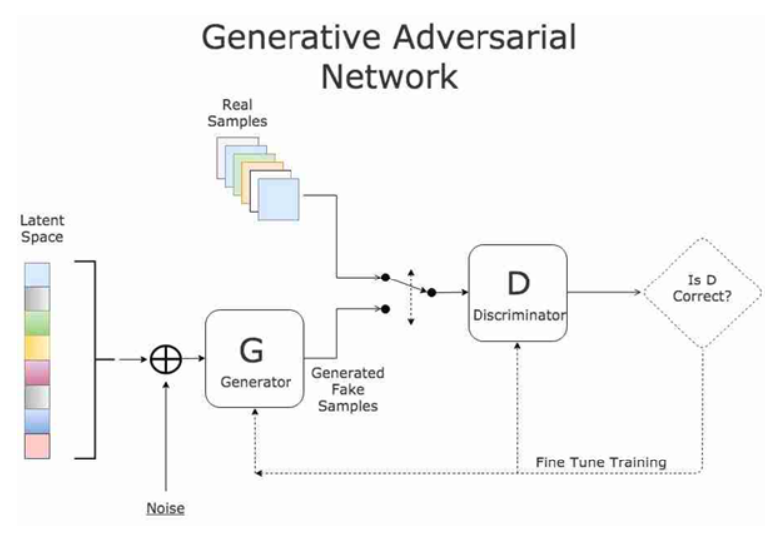

In [0]:
"""
Displaying the U-Net Structure architechture.
"""
gan = Image.open('Screen/GAN.png').convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
def def_GAN(generator, discriminator, vgg_net1_1, vgg_net1_2, vgg_net1_3, vgg_net1_4, vgg_net1_5, vgg_net2_1, vgg_net2_2, vgg_net2_3, vgg_net2_4, vgg_net2_5, input_shape = (128, 128, 3)):
  

  """
   The function for creating GAN model.
  This function defines the GAN model using the generator and discriminator with 
  discriminator weight updations being freezed during training so that gradients
  flow only to the generator.
  
  So, that discrimnator doesn't dominates over the generator and generator never 
  captures the probability distribution of colored images.
  Parameters:
    
    g_model (keras.Model): The generator model initialized before.
    d_model (keras.Model): The discriminator model initialized before.
    
    vgg_net1_1 (keras.Model): The VGG19 model with layer 4 output initialized for the
      target images.
    
    vgg_net1_2 (keras.Model): The VGG19 model with layer 4 output initialized for the 
      generated images.

    vgg_net1_3 (keras.Model): The VGG19 model with layer 4 output initialized for the 
      generated images.
    
    vgg_net1_4 (keras.Model): The VGG19 model with layer 4 output initialized for the 
      generated images. 

   vgg_net1_5 (keras.Model ): The VGG19 model with layer 5 output initialized for generated images. 


    
    pixelLevelLoss_weight (float): The weight to be given to pixel level loss.
    
    totalVariationLoss_weight (float): The weight to be given to total variation loss.
    
    inp_shape (tuple): The input shape for initializing the GAN model.
 
 Returns:
    tensorflow.keras.Model: The initialized GAN model.
  """
  # To freez the dicrimator weights
  discriminator.trainable = False
  
  sketchImg = Input(input_shape)
  generator_out = generator([sketchImg])

  # Get Discriminator output The generated image is real or fake
  desc_out = discriminator([sketchImg, generator_out])

  # Original Color Image
  color_img = Input(input_shape)

  # Pixel Wise loss
  pixelLoss = pixelLevel_loss(color_img, generator_out)


  # VGG Layer 1 loss
  vgg1_out = vgg_net1_1([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg1_pre = vgg_net2_1([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer1loss = layer1_loss(vgg1_out, vgg1_pre)

  #VGG Layer 2 Loss
  vgg2_out = vgg_net1_2([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg2_pre = vgg_net2_2([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer2loss = layer2_loss(vgg2_out, vgg2_pre)

  # VGG Layer 3 Loss
  vgg3_out = vgg_net1_3([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg3_pre = vgg_net2_3([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer3loss = layer3_loss(vgg3_out, vgg3_pre)

  # VGG Layer 4 Loss
  vgg4_out = vgg_net1_4([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg4_pre = vgg_net2_4([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer4loss = layer4_loss(vgg4_out, vgg4_pre)

  # VGG Layer 5 Loss
  vgg5_out = vgg_net1_5([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg5_pre = vgg_net2_5([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer5loss = layer5_loss(vgg5_out, vgg5_pre)

  crossEntropyLoss = binaryCrossEntropy()
  

  model = Model(inputs = [sketchImg, color_img], outputs= desc_out)
  opt = Adam(lr = 0.0005, beta_1 = 0.5)


  #model.compile(loss= total_loss,optimizer=opt)
  model.compile(loss=[ lambda y_true, y_pred : tf.keras.losses.binary_crossentropy(y_true, y_pred)  + \
                                              88.0 * pixelLoss(y_true, y_pred) +\
                                              79.0 * layer1loss(y_true, y_pred) +\
                                              63.0 * layer2loss(y_true, y_pred) +\
                                              51.0 * layer3loss(y_true, y_pred) +\
                                              39.0 * layer4loss(y_true, y_pred) +\
                                              107.0 * layer5loss(y_true, y_pred) ] ,optimizer=opt)

  return model

In [35]:
g_model = Generator()
d_model = Discriminator()

gan_model = def_GAN(g_model, d_model, vgg_net1_1, vgg_net1_2, vgg_net1_3, vgg_net1_4, vgg_net1_5, vgg_net2_1, vgg_net2_2, vgg_net2_3, vgg_net2_4, vgg_net2_5 )

gan_model.summary()

Encoder
Decoder
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_12 (Model)                (None, 128, 128, 3)  41941271    input_10[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_13 (Model)                (None, 1)            2220097     input_10[0][0]                   
                                                                 model_12[1

In [0]:
# https://towardsdatascience.com/sketch-to-color-anime-translation-using-generative-adversarial-networks-gans-8f4f69594aeb
def write_log(callback, name, loss, batch_no, flush=False):
    """
    A function for maintaining logs.

    The function writes the training summary to TensorBoard callback provided.

    Parameters:
      callback (keras.callbacks.TensorBoard): The tensorboard callback reference for writing the loss values to the event file.
      
      name (string): The name of the loss to be logged by the tensorboard. 
      
      loss (float): The loss value to be logged by the tensorboard. 
      
      batch_no (int): The batch number to be used for the loss.
      
      flush (boolean): To write out the buffered logs to the event file.
    """
    
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.tag = name
    summary_value.simple_value = loss
    callback.writer.add_summary(summary, batch_no)
    
    if flush:
      callback.writer.flush()

In [0]:

def save_plot(examples, epoch, n=3):
  """
  A function for saving intermediate output.

  The function saves plot of the generated color images by the generator for seed/fixed sketches that are loaded  
  before we start training.

  Parameters:
    examples (numpy.array): The colored images by the generator.
    
    epoch (int): The epoch at which the colored images are generated.
    
    n (int): The number of colored images generated.
  """

  n = int(math.sqrt(n))
  plt.figure(figsize=(6, 6))
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i])
  
  filename = '/content/gdrive/My Drive/Case Study 2/Image1/generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.show()

__PSNR Peak Signal-to-Noise Ratio__     
To find out the difference between generated and original image. It takes a pixel wise loss. The value is between 0 to 100. 0 for no match and 100 for perfect match.
    <img src="screen/PSNR.png"  height="200" width="300">

In [0]:
# https://cvnote.ddlee.cn/2019/09/12/PSNR-SSIM-Python.html
def calculate_psnr(img1, img2):
    """
    This function calculate PSNR score
    parameters:
      
      img1: Original color image
      
      img2: Generated color image from GAN network

    Return: 

      PSNR score of twot images if score are mode 100 then exact match  
    """
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse)) # ,mse

__Structure Similarity (SSIM) :__ Instead of doing pixel wise independent similarity in SSIM take a group of pixels and try to determine if two images are different or not. It is between -1 and 1. Positive 1 is perfect match and -1 for imperfect match.

<img src="screen/SSIM For.png"  height="300" width="500">



In [0]:
# https://cvnote.ddlee.cn/2019/09/12/PSNR-SSIM-Python.html
def ssim(img1, img2):
    """
    This function calculate SSIM scroe
    Paramerters:
      img1: Real image
      
      img3: Genertor created image
      
    Returns: 
    SSIM score it score is it is between -1 to 1 if 1 then images are 
    more similar and -1 then images are not similar
    """
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

def calculate_ssim(img1, img2):
    '''
    This function returns SSIM scroe
    Paramerters:
    
      img1: Real image

      img3: Genertor created image
      
    Returns: SSIM score it score is it is between -1 to 1 if 1 then images are 
    more similar and -1 then images are not similar

    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [0]:
def cal_psnr_ssim(g_model, epoch_number, sketch_paths = sketch_paths, img_paths = img_paths, test_sketch_paths = test_sketch_paths, test_img_paths = test_img_paths):


  j = epoch_number
  train_psnr = []
  train_ssim = []

  test_psnr = []
  test_ssim = []

  

  for i in range (10): 
    idxs = np.random.randint(0, TOTAL_IMAGES, 1)
    idx2 = np.random.randint(0, TOTAL_TEST_IMAGES, 1)
    temp_skets = [] 
    temp_skets2 = []

    temp_skets.append(np.array(Image.open(sketch_paths[idxs[0]]).convert('RGB')))
    train_src = np.array(Image.open(img_paths[idxs[0]]).convert('RGB'))

    temp_skets = (np.array(temp_skets, dtype = 'float32') / 127.5 -1)

    pred = g_model.predict(temp_skets)
    pred = (pred + 1) * 127.5
    
    #print (pred.shape)
    train_psnr.append(calculate_psnr(train_src, pred[0]))
    train_ssim.append(calculate_ssim(train_src, pred[0]))

    idx2 = np.random.randint(0, TOTAL_TEST_IMAGES, 1)
    

    temp_skets2.append(np.array(Image.open(test_sketch_paths[idx2[0]]).convert('RGB')))
    train_src = np.array(Image.open(test_img_paths[idx2[0]]).convert('RGB'))

    temp_skets2 = np.array(temp_skets2, dtype = 'float32') / 127.5 -1

    pred = g_model.predict(temp_skets2)
    pred = (pred + 1) * 127.5

    test_psnr.append(calculate_psnr(train_src, pred[0]))
    
    test_ssim.append(calculate_ssim(train_src, pred[0]))

  

  write_log(tensorboard_PNSR_callback, 'Train PNSR', np.mean(train_psnr), j+1, (j+1)%3==0)
  write_log(tensorboard_SSIM_callback, 'Train SSIM', np.mean(train_ssim), j+1, (j+1)%3==0)
  
  print ("Train PNSR:", np.mean(train_psnr))
  print ("Test PNSR:",np.mean(test_psnr))

  print ("Train SSIM:",np.mean(train_ssim))
  print ("Test SSIM ",np.mean(test_ssim))

#cal_psnr_ssim(g_model)


In [0]:
def summarize_performance(epoch, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, n_samples = 9):
  
  """
  A function for summarzing the logs after an epoch.

  The function summarizes the accuracy of discriminator of 
  how similar is colored image compared to target color image
  and saved the generator model after each epoch.

  Parameters:
    epoch (int): The epoch at which the colored images are to be generated for summary.
    
    g_model (keras.model): The trained generator model after an epoch. 
    
    d_model (keras.model): The trained discriminator model after an epoch.
    
    sketch_paths (numpy.array): The paths to the black-and-white sketches i.e input images.
    
    image_paths (numpy.array): The paths to the colored images i.e target images.
    
    latent_dim (int): The dimesnions of latent/random vector(z).
    
    seed_skets (numpy.array): The fixed black-and-white sketches for checking the generator output after every epoch.
    
    seed_imgs (numpy.array): The fixed colored images for checking the generator output after every epoch.
    
    n_samples (int): The # colored images to be generated during summary.
  """
  
  X_real_sketches, X_real_images, y_real = generate_real_samples(sketch_paths, image_paths, n_samples)
  _, acc_real = d_model.evaluate([X_real_sketches, X_real_sketches], y_real, verbose=0)

  X_fake_sketches, x_fake_images, y_fake = generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, n_samples, seed_skets = seed_skets, seed_imgs = seed_imgs)
  _, acc_fake = d_model.evaluate([X_fake_sketches, x_fake_images], y_fake, verbose=0)

  print ('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))

  save_plot(x_fake_images, epoch, n_samples)
  
  filename = 'generator_model_%03d.h5' %(epoch +1)
  g_model.save(filename)

In [0]:
def generate_real_samples(sketch_paths, image_paths, n_samples):
    """
  A function to load black-and-white sketches and colored images for the discriminator.

  The function loads the black-and-white sketches and corresponding colored images from the given paths 
  for training the discriminator.

  Parameters:
    sketch_paths (numpy.array): The paths to the black-and-white sketches i.e input images.
    
    image_paths (numpy.array): The paths to the colored images i.e target images.
    
    n_samples (int): The # samples to load for training process.
    
    offset (int): The offset value for loading images if it's not random sampling.

  Returns:
    numpy.array: The loaded black-and-white sketches.
    
    numpy.array: The loaded colored images.
    
    numpy.array: The output values for binary cross entropy.
 """

  ix = np.random.randint(0, TOTAL_IMAGES, n_samples)
  X_sketches = []
  X_images = []

  for sket, img in zip(sketch_paths[ix], image_paths[ix]):

    X_sketches.append(np.array(Image.open(sket).convert('RGB')))
    X_images.append(np.array(Image.open(img).convert('RGB')))

  X_sketches = (np.array(X_sketches, dtype ='float32') - 127.5) / 127.5 
  X_images = (np.array(X_images, dtype = 'float32') - 127.5) / 127.5  
  y = np.ones((n_samples, 1))  
  return X_sketches, X_images, y




In [0]:
def generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, n_samples, seed_skets = None, seed_imgs = None):

  """
    A function to load black-and-white sketches and colored images for GAN.

  The function loads the black-and-white sketches and corresponding colored images from the given paths 
  for training the GAN.

  Parameters:
    g_model (keras.model): The trained generator model after an epoch.
    
    sketch_paths (numpy.array): The paths to the black-and-white sketches i.e input images.
    
    image_paths (numpy.array): The paths to the colored images i.e target images.
    
    latent_dim (int): The dimesnions of latent/random vector(z).
    
    n_samples (int): The # samples to load for training process.
    
    seed_skets (numpy.array): The fixed black-and-white sketches for checking the generator output after every epoch.
    
    seed_imgs (numpy.array): The fixed colored images for checking the generator output after every epoch.

  Returns:
    numpy.array: The loaded black-and-white sketches.
    
    numpy.array: The loaded colored images.
    
    numpy.array: The output values for binary cross entropy.
  """

  X_sketches = []
  X_images = []

  if seed_skets is not None:

    X_images = g_model.predict(seed_skets)
    y = np.zeros((n_samples, 1))

    return seed_skets, X_images, y

  elif g_model is not None:
    
    ix = np.random.randint(0, TOTAL_IMAGES, n_samples)

    for sket in sketch_paths[ix]:
      X_sketches.append(np.array(Image.open(sket).convert('RGB')))

    X_sketches = (np.array(X_sketches, dtype = 'float32') - 127.5)/127.5
    X_images = g_model.predict(X_sketches)
    y = np.zeros((n_samples, 1))

    return X_sketches, X_images, y

  else:
    return generate_real_samples(sketch_paths, image_paths, n_samples)

  

In [0]:
def train(g_model, d_model, gan_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, output_frequency, n_epochs=100, n_batch=128, init_epoch=0):

    """
    Function for training GAN

    The function defines the training the discriminator and the generator alternatively 
    so that gradients flow into only either one of them.
  
    Also prints the loss of discriminator real & generated colored images for every nth batch.

    Parameters:
    g_model (keras.model): The generator model for getting colored during summary. 
    
    d_model (keras.model): The discriminator model that to be trained.
    
    gan_model (keras.model): The GAN model that to be trained.
    
    sketch_paths (numpy.array): The paths to the black-and-white sketches i.e input images.
    
    image_paths (numpy.array): The paths to the colored images i.e target images.
    
    latent_dim (int): The dimesnions of latent/random vector(z).
    
    seed_skets (numpy.array): The fixed black-and-white sketches for checking the generator output after every epoch.
    
    seed_imgs (numpy.array): The fixed colored images for checking the generator output after every epoch.
    
    output_frequency (int): The batch frequency at which to print the loss values on the console.  
    
    n_epochs (int): The # epochs for training the discriminator and GAN.
    
    n_batch (int): The batch size for every epoch training.
    
    init_epoch (int): The initial epoch at which to start training process, 
      useful for resuming the training process from a particular epoch.

  """
  # number of images per batch
  bat_per_epo = int(TOTAL_IMAGES/ n_batch)
  half_batch = int(n_batch / 2)

  for i in range(init_epoch, n_epochs):

    start = datetime.now()
    gen_losses = []
    dis_losses = []


    for j in range(bat_per_epo):


      if not j%2: 
          X_real_skets, X_real_imags, y_real = generate_real_samples(sketch_paths, image_paths, half_batch)
          d_loss1, _ = d_model.train_on_batch([X_real_skets, X_real_imags], y_real * 0.9)

      if not j%3:

          X_fake_skets, X_fake_imgs, y_fake = generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, half_batch)
          d_loss2, _ = d_model.train_on_batch([X_fake_skets, X_fake_imgs], y_fake)

      d_loss = 0.5 * (d_loss1 + d_loss2)

      X_gan_skets, X_gan_imgs, _ = generate_fake_samples(None, sketch_paths, image_paths, latent_dim, n_batch)

      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch([X_gan_skets, X_gan_imgs], y_gan)

      dis_losses.append(d_loss)
      gen_losses.append(g_loss)

      #print (j)
      if not j % output_frequency:
          print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))


    # Save losses to Tensorboard after every epoch.
    write_log(tensorboard_disc_callback, 'discriminator_loss', np.mean(dis_losses), i+1, (i+1)%3==0)
    write_log(tensorboard_gen_callback, 'generator_loss', np.mean(gen_losses), i+1, (i+1)%3==0)

    display.clear_output(True)
    print('Time for epoch {} : {}'.format(i+1, datetime.now()-start))
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    cal_psnr_ssim(g_model, i, sketch_paths, img_paths, test_sketch_paths, test_img_paths)
    summarize_performance(i, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, seed_skets.shape[0])
  
  display.clear_output(True)      
  print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  cal_psnr_ssim(g_model, i, sketch_paths, img_paths, test_sketch_paths, test_img_paths)
  summarize_performance(i, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, seed_skets.shape[0])


In [0]:
!rm -rf ./logs/ 

"""
Tensorboard callbacks for logging generator and discriminator loss.
"""

logdir_g_model = "logs/generator/" 
tensorboard_gen_callback = TensorBoard(log_dir=logdir_g_model)
tensorboard_gen_callback.set_model(g_model)

logdir_d_model = "logs/discriminator/"
tensorboard_disc_callback = TensorBoard(log_dir=logdir_d_model)
tensorboard_disc_callback.set_model(d_model)

#logdir_gan_model = "logs/gan/"
#tensorboard_gan_callback = TensorBoard(log_dir=logdir_gan_model)
#tensorboard_gan_callback.set_model(gan_model)

logdir_PSNR_loss = "logs/PNSR/"
tensorboard_PNSR_callback = TensorBoard(log_dir=logdir_PSNR_loss)
tensorboard_PNSR_callback.set_model(g_model)

logdir_SSIM_loss = "logs/SSIM/"
tensorboard_SSIM_callback = TensorBoard(log_dir=logdir_SSIM_loss)
tensorboard_SSIM_callback.set_model(g_model)

"""
Launching the tensorboard.
"""

#%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [0]:
#!kill 807
%load_ext tensorboard
%tensorboard --logdir logs


__Load Weights__

In [0]:
def loadWeights(gan, generator, discriminator):
    if (os.path.isfile('/content/gdrive/My Drive/Case Study 2/weights/generatorWT1.h5')):
      gan.load_weights('/content/gdrive/My Drive/Case Study 2/weights/ganWT1.h5')
      generator.load_weights('/content/gdrive/My Drive/Case Study 2/weights/generatorWT1.h5')
      discriminator.load_weights('/content/gdrive/My Drive/Case Study 2/weights/discriminatorWT1.h5')

loadWeights(gan_model, g_model, d_model)

__Train GAN__

>30, 743/743, d1=0.354, d2=0.000 g=327.960
Train PNSR: 15.534805275985807
Test PNSR: 15.58172534146471
Train SSIM: 0.6668460799384278
Test SSIM  0.5989581226081555
>Accuracy real: 0%, fake: 100%


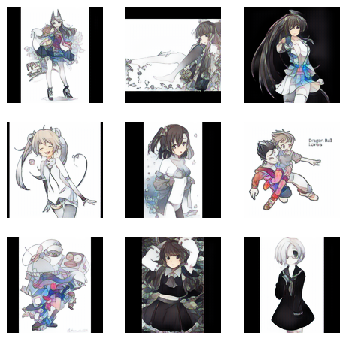

In [0]:
seed_skets = []
seed_imgs = []
#print (TOTAL_IMAGES)
idxs = np.random.randint(0, TOTAL_IMAGES, 10)
#print (type(idxs))

cnt = 0
for sket, img in zip(sketch_paths[idxs], img_paths[idxs]):
    seed_skets.append(np.array(Image.open(sket).convert('RGB')))
    seed_imgs.append(np.array(Image.open(img).convert('RGB')))

"""
Normalizing the values to be between [-1, 1].
""" 
seed_skets = (np.array(seed_skets, dtype='float32')-127.5)/127.5
seed_imgs = (np.array(seed_imgs, dtype='float32')-127.5)/127.5


# ======================================= Start training ======================================= #
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs= 30, n_batch=8, init_epoch= 0)


In [0]:
def saveWeights(gan, generator, discriminator):

    """
    This function is used to Store weight of the model on disk so we can use same weights for next time
    Parameters:
        gan(keras.model): GAN model

        generatro(keras.model): Genrarator model

        discriminator(keras.model): Discriminator model
    """
    #discriminator.trainable = False
    gan.save_weights( '/content/gdrive/My Drive/Case Study 2/weights/ganWT.h5', overwrite=True)
    #discriminator.trainable = True
    generator.save_weights('/content/gdrive/My Drive/Case Study 2/weights/generatorWT.h5', overwrite=True)
    discriminator.save_weights('/content/gdrive/My Drive/Case Study 2/weights/discriminatorWT.h5', overwrite=True)

saveWeights(gan_model, g_model, d_model)

>35, 743/743, d1=0.327, d2=0.002 g=322.002
Train PNSR: 8.252957615663718
Test PNSR: 5.158582562320835
Train SSIM: 0.46511978839407186
Test SSIM  0.2522033152070515
>Accuracy real: 20%, fake: 80%


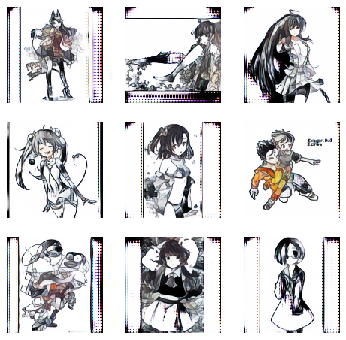

In [0]:
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs=35, n_batch=8, init_epoch=30)
saveWeights(gan_model, g_model, d_model)

Time for epoch 47 : 0:05:23.409114
>47, 743/743, d1=0.327, d2=0.002 g=310.485
Train PNSR: 8.034148079064945
Test PNSR: 7.061996331713324
Train SSIM: 0.3742015392820726
Test SSIM  0.36001675668757105
>Accuracy real: 0%, fake: 100%


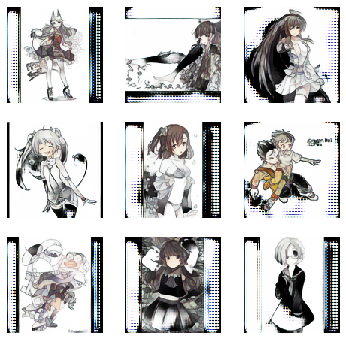

>48, 1/743, d1=0.333, d2=0.002 g=292.910


In [0]:
## Train and store weights of the models
for i in range(30, 100, 5):
  train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs= i+5, n_batch=8, init_epoch=i)
  saveWeights(gan_model, g_model, d_model)

>57, 743/743, d1=0.331, d2=0.033 g=266.608
Train PNSR: 17.72473901306356
Test PNSR: 16.339599197045622
Train SSIM: 0.7016306423545768
Test SSIM  0.7702794158602809
>Accuracy real: 10%, fake: 20%


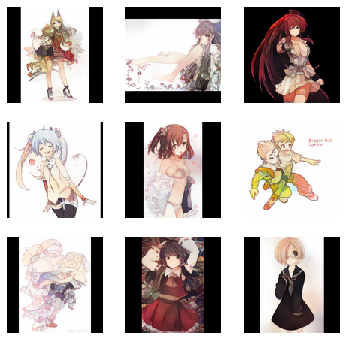

In [0]:


# ======================================= Start training ======================================= #
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs= 57, n_batch=8, init_epoch= 56)



In [0]:
def saveWeights(gan, generator, discriminator):

    """
    This function is used to Store weight of the model on disk so we can use same weights for next time
    Parameters:
        gan(keras.model): GAN model

        generatro(keras.model): Genrarator model

        discriminator(keras.model): Discriminator model
    """
    #discriminator.trainable = False
    gan.save_weights( '/content/gdrive/My Drive/Case Study 2/weights/ganWT1.h5', overwrite=True)
    #discriminator.trainable = True
    generator.save_weights('/content/gdrive/My Drive/Case Study 2/weights/generatorWT1.h5', overwrite=True)
    discriminator.save_weights('/content/gdrive/My Drive/Case Study 2/weights/discriminatorWT1.h5', overwrite=True)

saveWeights(gan_model, g_model, d_model)

### Results: 

### Predicted results on Train Data

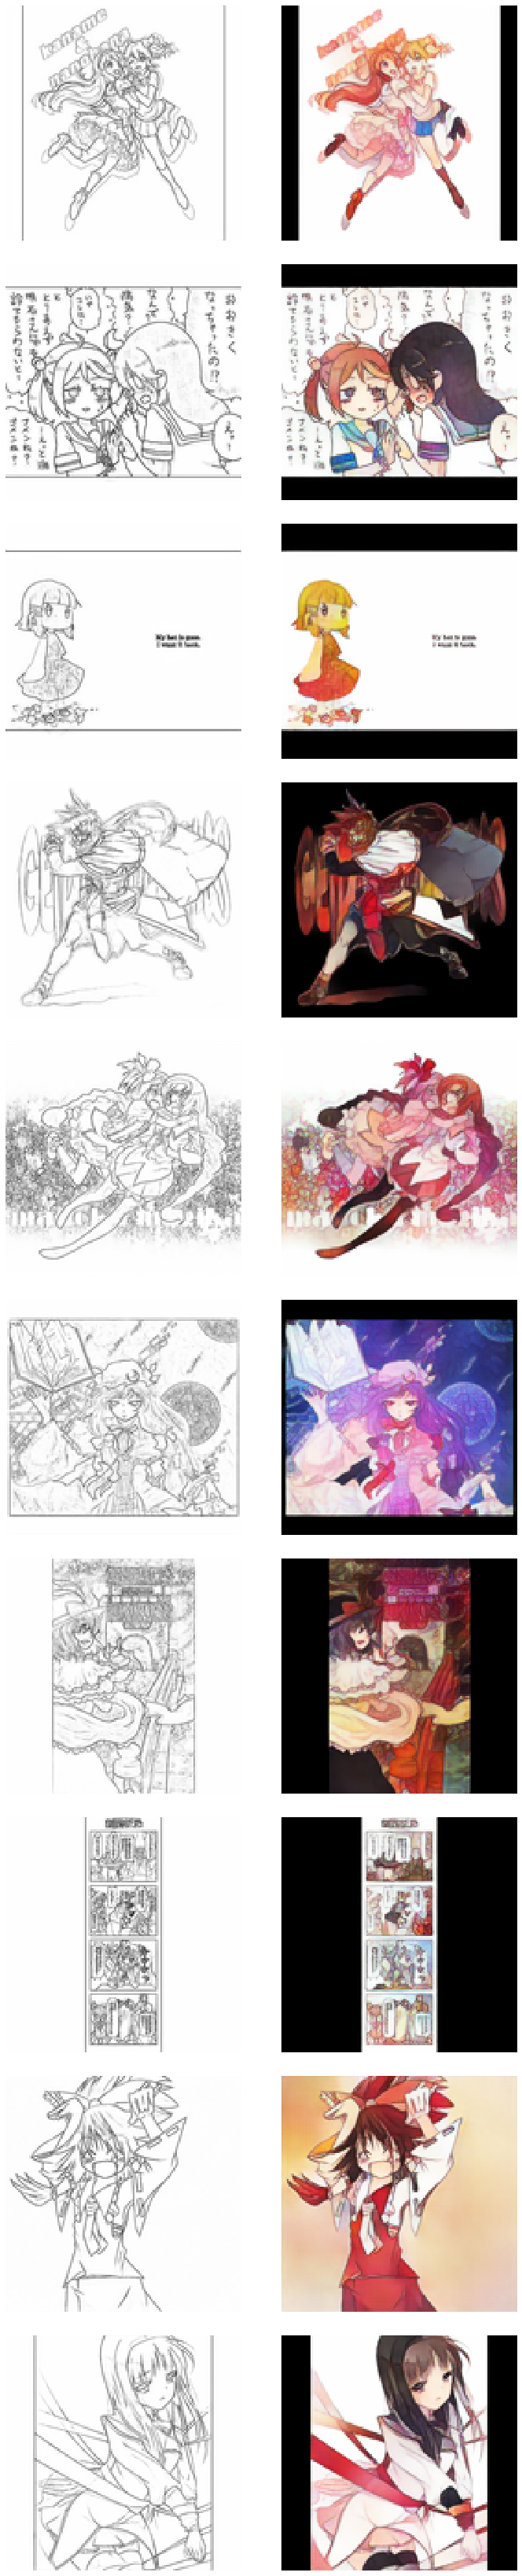

In [37]:
k = 10 
temp_skets = [] 
temp_imgs = [] 
idxs = np.random.randint(1000, TOTAL_IMAGES , k) 

for sket, img in zip(sketch_paths[idxs], img_paths[idxs]):    
  temp_skets.append(np.array(Image.open(sket).convert('RGB')))    
  temp_imgs.append(np.array(Image.open(img).convert('RGB'))) 
  
temp_skets = np.array(temp_skets, dtype='float32')/127.5 - 1 

pred = g_model.predict(temp_skets) 
pred = (pred+1)/2.0 

temp_skets = (temp_skets+1)/2.0 
f, a = plt.subplots(k, 2, figsize=(12,60)) 
a = a.flatten() 
idx = 0 

for sket, pic in zip(temp_skets, pred):  
  a[idx].imshow(sket)  
  a[idx+1].imshow(pic)  
  a[idx].axis('off')  
  a[idx+1].axis('off')  
  idx += 2 
  
plt.subplots_adjust(wspace=.1, hspace=.1) 
plt.show()

### Predicted Results on TEST data

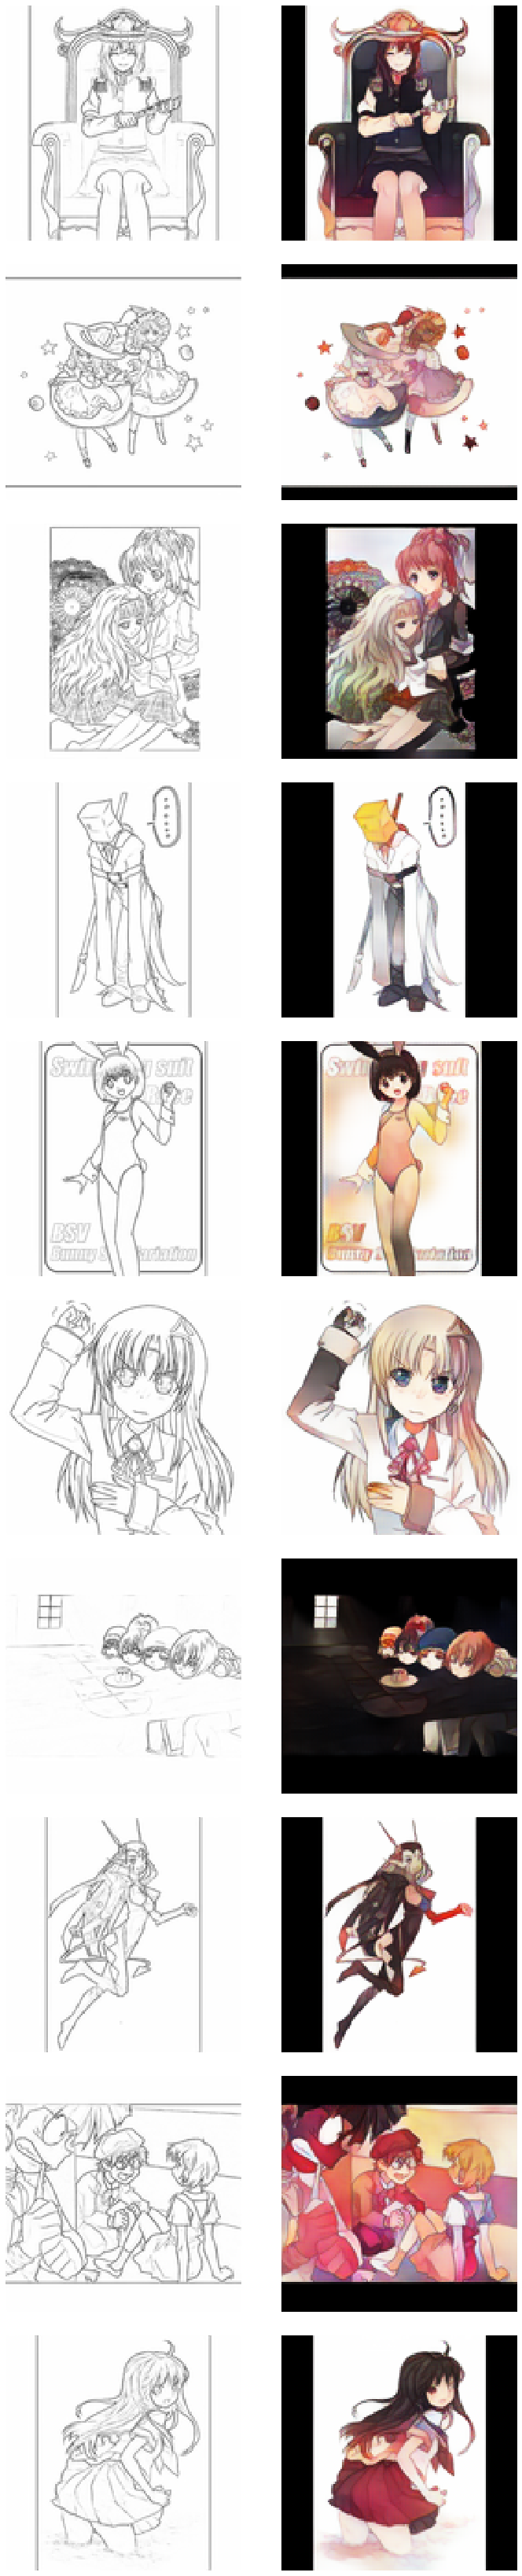

In [39]:
k = 10 
temp_skets = [] 
temp_imgs = [] 
idxs = np.random.randint(1000, TOTAL_TEST_IMAGES , k) 

for sket, img in zip(test_sketch_paths[idxs], test_img_paths[idxs]):    
  temp_skets.append(np.array(Image.open(sket).convert('RGB')))    
  temp_imgs.append(np.array(Image.open(img).convert('RGB'))) 
  
temp_skets = np.array(temp_skets, dtype='float32')/127.5 - 1 

pred = g_model.predict(temp_skets) 
pred = (pred+1)/2.0 

temp_skets = (temp_skets+1)/2.0 
f, a = plt.subplots(k, 2, figsize=(12,60)) 
a = a.flatten() 
idx = 0 

for sket, pic in zip(temp_skets, pred):  
  a[idx].imshow(sket)  
  a[idx+1].imshow(pic)  
  a[idx].axis('off')  
  a[idx+1].axis('off')  
  idx += 2 
  
plt.subplots_adjust(wspace=.1, hspace=.1) 
plt.show()

In [0]:
from tensorflow.keras.models import save_model, load_model

def saveModels(gan, generator, discriminator):
    save_model(gan, '/content/gdrive/My Drive/Case Study 2/NewModel/gan.h5')
    save_model(generator, '/content/gdrive/My Drive/Case Study 2/NewModel/generator.h5')
    save_model(discriminator, '/content/gdrive/My Drive/Case Study 2/NewModel/discriminator.h5')

saveModels(gan_model, g_model, d_model)

#### Observations:
    1. I got 0.70 and 0.77 SSIM score on train and test data and it increases as epoches increases.
    2. I got 17 PNSR score which is also increase as epoch increases.
    3. As the epoch inceases the loss also reduces.
    4. If we run for more epoch then you will get more clear images.
    5. Train a GAN take a time.    

__References__: 
    1. SGRU GAN http://www.engineeringletters.com/issues_v27/issue_3/EL_27_3_01.pdf </link>
    2. Anime Sketch Colorization Keras https://towardsdatascience.com/sketch-to-color-anime-translation-using-generative-adversarial-networks-gans-8f4f69594aeb
    3. Tip and tricks of GAN https://github.com/soumith/ganhacks
    4. Image comparision (Similarity Between images) https://cvnote.ddlee.cn/2019/09/12/PSNR-SSIM-Python.html
    